# ARIMA modelling on Covid 19 Dataset

In [37]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt


### Read Data

In [58]:
dataset = pd.read_csv(r'Data2.csv')

dataset.head(5)


,Data as of,State,MMWR Week,End Week,Sex,Age Group,Total Deaths,COVID-19 Deaths
0,03/16/2022,United States,1,01/04/2020,All Sex,All Ages,60164,0
1,03/16/2022,United States,1,01/04/2020,All Sex,Under 1 year,402,0
2,03/16/2022,United States,1,01/04/2020,All Sex,1-4 Years,79,0
3,03/16/2022,United States,1,01/04/2020,All Sex,5-14 Years,99,0
4,03/16/2022,United States,1,01/04/2020,All Sex,15-24 Years,605,0


# Data Preprocessing

In [59]:
dataset.drop('End Week',axis=1,inplace=True)

# Filter
dataset = dataset[(dataset["Sex"] == 'Female') & (dataset["Age Group"]=='45-54 Years')]

dataset.drop('Sex',axis=1,inplace=True)
dataset.drop('State',axis=1,inplace=True)
dataset.drop('Total Deaths',axis=1,inplace=True)
dataset.drop('Age Group',axis=1,inplace=True)
dataset.drop('MMWR Week',axis=1,inplace=True)
dataset.drop('Data as of',axis=1,inplace=True)
dataset_copy = dataset.copy()
timeseries = dataset.copy()

In [60]:
dataset.head(5)

,COVID-19 Deaths
31,0
67,0
103,0
139,1
175,0


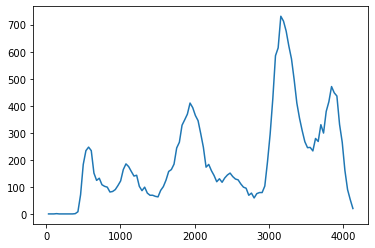

In [61]:
plt.plot(dataset)
plt.show()

## Auto Correlation ------------->

### The plot includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. 
### Correlation values above these lines are more significant than those below the line, 
### providing a threshold or cutoff for selecting more relevant lag values.

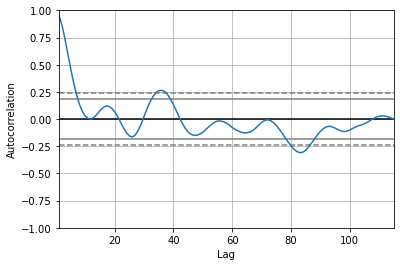

In [62]:

autocorrelation_plot(timeseries)
plt.show()
# This shows that a value around 31-40 is a good choice for lag value

## Moving Average Technique ----------->

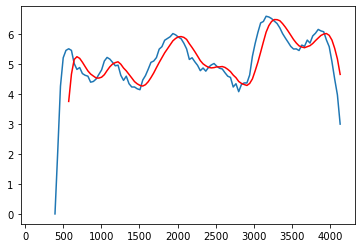

In [63]:

ts_log = np.log(timeseries)

moving_avg = ts_log.rolling(6).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(6)

ts_log_moving_avg_diff.dropna(inplace=True)

In [64]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    ts_log = np.log(timeseries)

    rolmean = ts_log.rolling(5).mean()
    rolstd = ts_log.rolling(5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries["COVID-19 Deaths"], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Moving Average and Removing Stationarity
### Here we have just demonstrated the moving average method tracing the prediction
### The Stationarity can be removed by the Rolling mean method

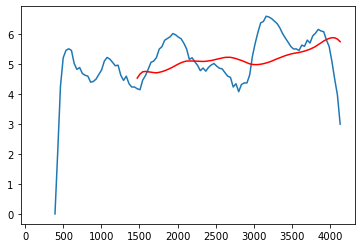

In [65]:
ts_log = np.log(timeseries)
moving_avg = ts_log.rolling(31).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')



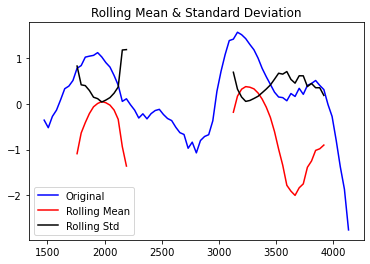

Results of Dickey-Fuller Test:
Test Statistic                 -2.082545
p-value                         0.251591
#Lags Used                      2.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [66]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(5)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

# ARIMA -----------> 
### Train / Validation set

In [67]:
train = dataset[:int(0.7*(len(dataset)))]
valid = dataset[int(0.7*(len(dataset))):]

In [68]:
# pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=735.875, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=756.621, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=732.191, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=738.874, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=754.719, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=733.884, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=733.941, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=734.315, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=730.225, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=731.915, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=731.972, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=736.930, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=732.354, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.451 seconds


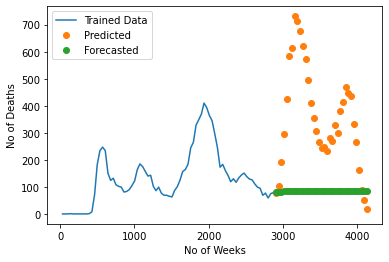

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -363.112
Date:                Thu, 24 Mar 2022   AIC                            730.225
Time:                        13:23:43   BIC                            734.963
Sample:                             0   HQIC                           732.123
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5300      0.086      6.194      0.000       0.362       0.698
sigma2       572.7779     76.143      7.522      0.000     423.540     722.016
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [69]:
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit = model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set


plt.plot(train, label='Train')
plt.plot(valid,'o', label='Valid')
plt.plot(forecast,'o', label='Prediction')
plt.xlabel("No of Weeks")
plt.ylabel("No of Deaths")
plt.legend(["Trained Data","Predicted ","Forecasted"], loc ="upper left")
plt.show()
print(model.fit(train).summary())

### Error calculation

In [74]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid,forecast))

print('Test RMSE: %.4f' % rms)

Test RMSE: 329.5327


## ACF and PACF function Plots ------->

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv(r'All Ages All Sex.csv')

# Plotting Functions ------> 
fig, axes = plt.subplots(3, 3, sharex=True)

# Original Series
axes[0, 0].plot(df['COVID-19 Deaths']); axes[0, 0].set_title('Original Series')
plot_acf(df['COVID-19 Deaths'], ax=axes[0, 1])
plot_pacf(df['COVID-19 Deaths'], ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(df['COVID-19 Deaths'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['COVID-19 Deaths'].diff().dropna(), ax=axes[1, 1])
plot_pacf(df['COVID-19 Deaths'].diff().dropna(), ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(df['COVID-19 Deaths'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['COVID-19 Deaths'].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df['COVID-19 Deaths'].diff().diff().dropna(), ax=axes[2, 2])



plt.show()

In [ ]:
plot_acf(timeseries.diff().diff().dropna(), lags=25)
plt.show()


In [ ]:
plot_pacf(timeseries.diff().diff().dropna(), lags=31)
plt.show()

### Count of values above the threshold indicates the value of q in ACF and p in PACF

# 

In [44]:
#residuals = pd.Dataframe(model_fit.resid)
#residuals.plot()
#plt.show()
# # density plot of residuals
#residuals.plot(kind='kde')
#plt.show()
# # summary stats of residuals
#print(residuals.describe())


C:\Users\SAMEER\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


115
predicted=19889.337953, expected=19397.000000
predicted=17515.278428, expected=16795.000000
predicted=13872.450048, expected=12844.000000
predicted=8787.033410, expected=8469.000000
predicted=4241.696070, expected=5144.000000
predicted=2705.849196, expected=2996.000000
predicted=1477.643001, expected=1010.000000
Test RMSE: 658.687


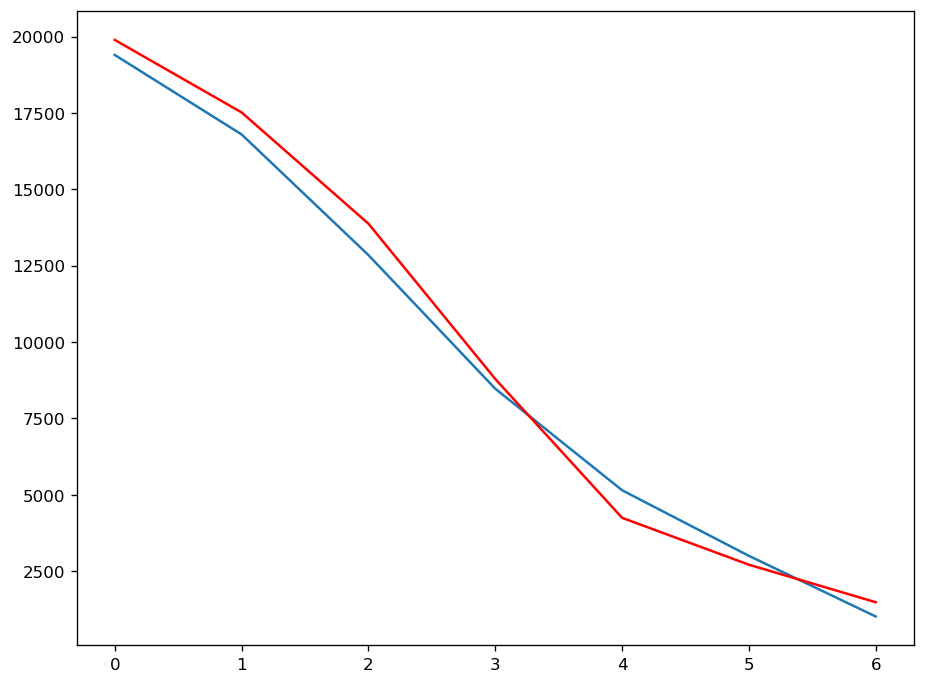

In [53]:

# split dataset
X = timeseries.values
print(len(X))
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()